In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [26]:
df = pd.read_csv('DataBase.csv')
df

,input,output,time
0,255,1008,2.160
1,255,821,2.175
2,255,699,2.190
3,255,495,2.250
4,255,472,2.265
...,...,...,...
2299,122,509,99.855
2300,122,456,99.900
2301,122,481,99.945
2302,122,467,99.990


In [27]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData  = np.arange(initTime, finalTime, T)
    
    lastValue = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


dt = 0.030
df['time'] = df.time - df.time[0]
df = normalizeTable(df, 'time', dt)
df.head()

,time,input,output
0,0.00,255,1008
1,0.03,255,699
2,0.06,255,699
3,0.09,255,495
4,0.12,255,472


In [28]:
def getStates(df, key, var='y', n=10):
    table = df.copy() 
    table[f'{var}[n-0]'] = table[key]

    for i in range(1, n):
        table[f'{var}[n-{i}]'] = table[key].shift(i)

    table.fillna(0, inplace=True)
    columns = [f'{var}[n-0]'] + [f'{var}[n-{i}]' for i in range(1, n)]
    return table[columns]


size = 10
yData = df.output.values
xData = getStates(df, 'input', 'x', size)
xData.head()

,x[n-0],x[n-1],x[n-2],x[n-3],x[n-4],x[n-5],x[n-6],x[n-7],x[n-8],x[n-9]
0,255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,255,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,255,255.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,255,255.0,255.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0
4,255,255.0,255.0,255.0,255.0,0.0,0.0,0.0,0.0,0.0


# MODELO PREDITIVO

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

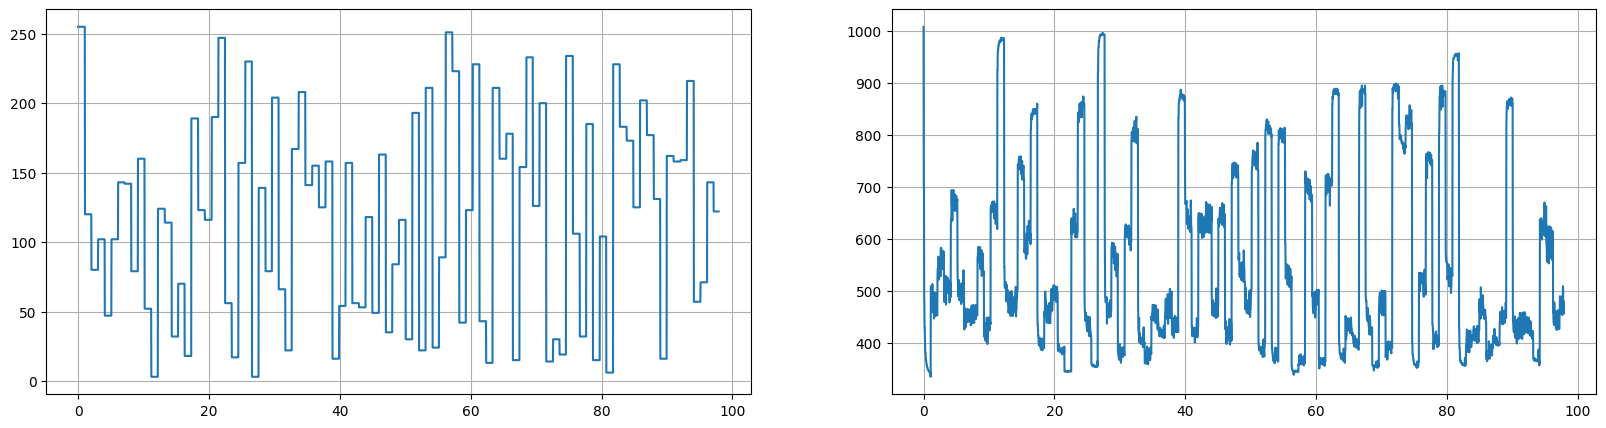

In [30]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(df.time, df.input)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df.time, df.output)
plt.grid()
plt.show()

### REGRESSÃO LINEAR

score: 0.857


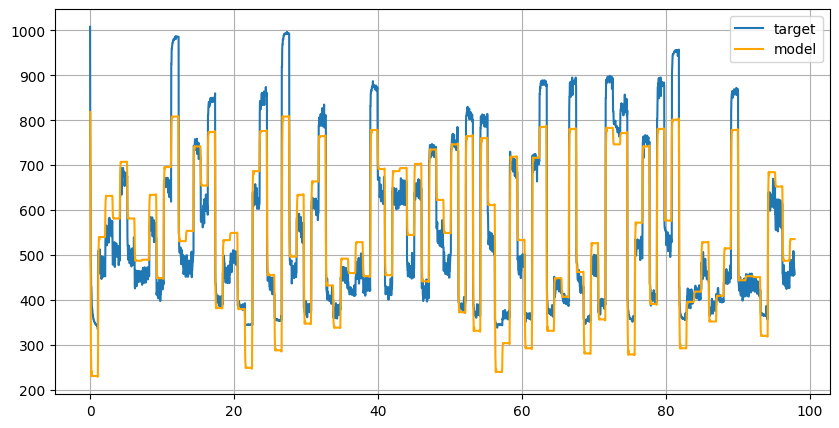

In [31]:
def linearRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = LinearRegression()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = linearRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='target')
plt.plot(df.time, yModel, color='orange', label='model')
plt.legend(), plt.grid()
plt.show()

### REGRESSÃO POLINOMIAL

score: 0.961


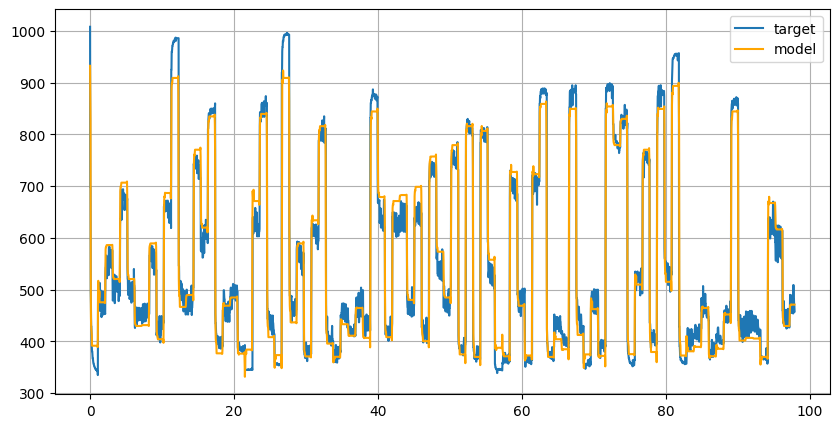

In [32]:
def polinomialRegression(xData, yData, degree=2):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = polinomialRegression(xData, yData, degree=2)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='target')
plt.plot(df.time, yModel, color='orange', label='model')
plt.legend(), plt.grid()
plt.show()

### ÁRVORE DE DECISÃO

score: 0.929


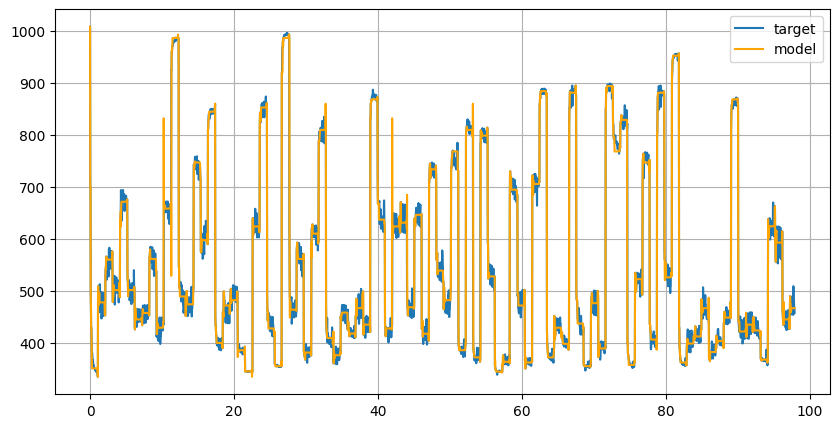

In [33]:
def decisionTreeRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = DecisionTreeRegressor()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = decisionTreeRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='target')
plt.plot(df.time, yModel, color='orange', label='model')
plt.legend(), plt.grid()
plt.show()

### RANDOM FOREST

score: 0.971


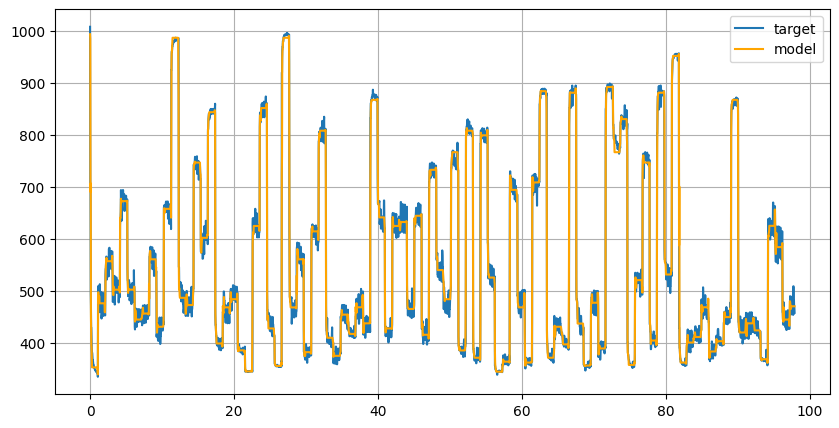

In [34]:
def randomForestRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = RandomForestRegressor()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = randomForestRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='target')
plt.plot(df.time, yModel, color='orange', label='model')
plt.legend(), plt.grid()
plt.show()

### SUPORTE VETORIAL PARA REGRESSÃO (SVR)

score: 0.864


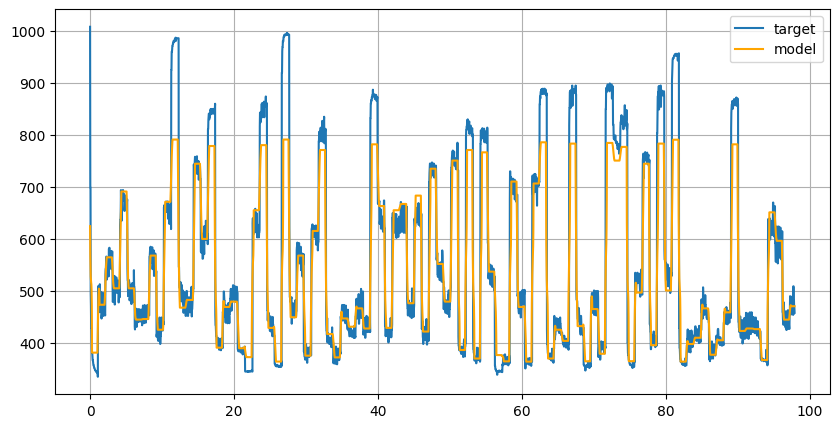

In [35]:
def supportVectorRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = SVR(kernel='rbf')  # kernel pode ser 'linear', 'poly', ou 'rbf'
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = supportVectorRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='target')
plt.plot(df.time, yModel, color='orange', label='model')
plt.legend(), plt.grid()
plt.show()

### RIDGE REGRESSOR

score: 0.848


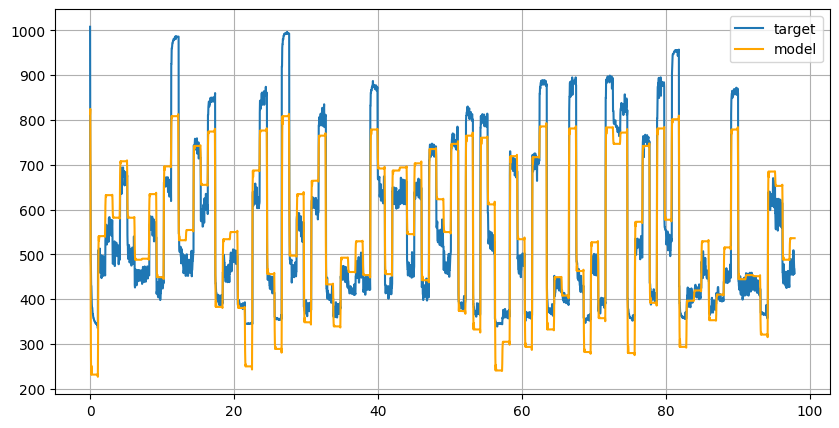

In [36]:
def ridgeRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = Ridge(alpha=1.0)  # Ajuste o parâmetro alpha para regularização
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = ridgeRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='target')
plt.plot(df.time, yModel, color='orange', label='model')
plt.legend(), plt.grid()
plt.show()

### GRADIENT BOOSTER

score: 0.963


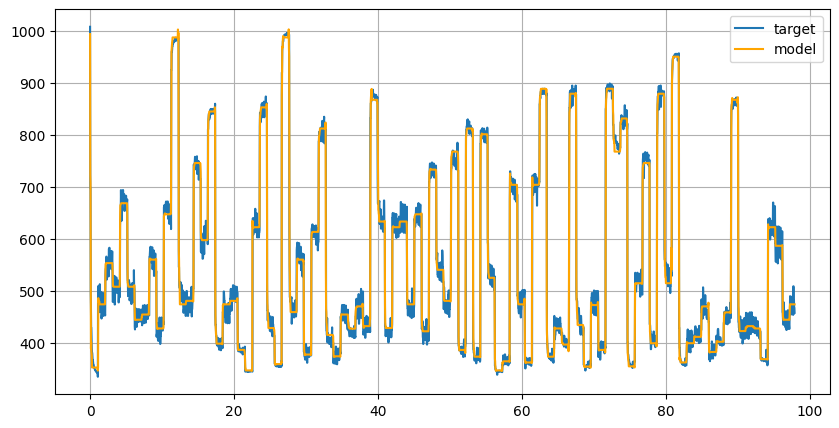

In [37]:
def gradientBoostingRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = gradientBoostingRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='target')
plt.plot(df.time, yModel, color='orange', label='model')
plt.legend(), plt.grid()
plt.show()

### K-NEAREST NEIGHBORS

score: 0.925


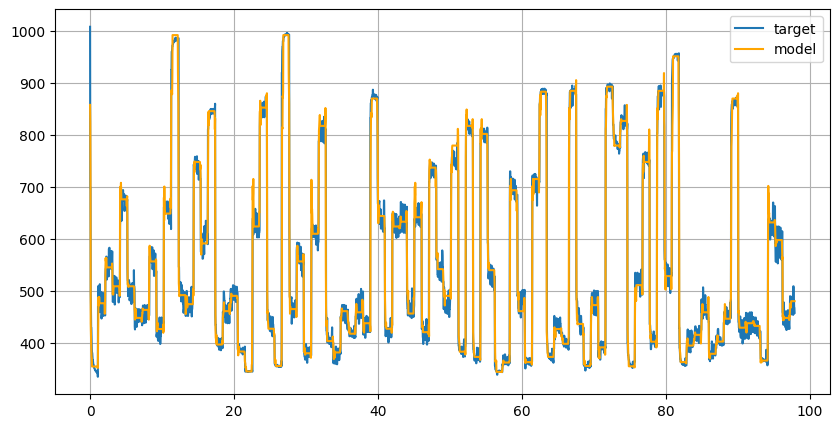

In [38]:
def knnRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.2)
    model = KNeighborsRegressor(n_neighbors=5)  # Ajuste n_neighbors conforme necessário
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = knnRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='target')
plt.plot(df.time, yModel, color='orange', label='model')
plt.legend(), plt.grid()
plt.show()

# TESTANDO COM NOVOS DADOS

In [39]:
class StatesUpdater:
    buffer  = None
    initial = 0
    size    = 0

    def __init__(self, size, initial=0):
        self.initial = initial
        self.size    = size
        self.buffer  = initial * np.ones(size)
        
    def update(self, value=None):
        for i in range(self.size-1, 0, -1):
            self.buffer[i] = self.buffer[i-1]
        
        self.setFirst(value)
        return self.buffer
    
    def setFirst(self, value):
        if value is not None:
            self.buffer[0] = value

    def reset(self):
        for i in range(self.size): self.buffer[i] = self.initial
    

states = StatesUpdater(3)
for i in range(1, 5): print(states.update(i))

[1. 0. 0.]
[2. 1. 0.]
[3. 2. 1.]
[4. 3. 2.]


In [40]:
df = pd.read_csv('DataBase.csv')
df.head()

,input,output,time
0,255,1008,2.160
1,255,821,2.175
2,255,699,2.190
3,255,495,2.250
4,255,472,2.265


In [41]:
columns = xData.columns
columns

Index(['x[n-0]', 'x[n-1]', 'x[n-2]', 'x[n-3]', 'x[n-4]', 'x[n-5]', 'x[n-6]',
       'x[n-7]', 'x[n-8]', 'x[n-9]'],
      dtype='object')

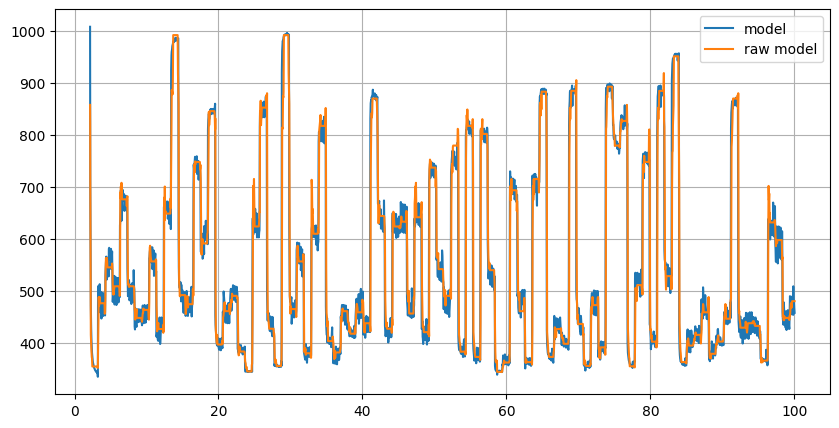

In [42]:
states = StatesUpdater(size)
yModel = []

for i, row in df.iterrows():
    xData  = np.array([states.update(row['input'])])
    yModel.append(model.predict(xData)[0])

plt.figure(figsize=(10, 5))
plt.plot(df.time, df.output, label='model')
plt.plot(df.time, yModel, label='raw model')
plt.legend(), plt.grid()
plt.show()

# SALVANDO MODELO

In [43]:
import joblib
joblib.dump(model, "model.pkl")

['model.pkl']

In [44]:
def getModel():
    size = 10
    path = r'../Model/model.pkl'
    return size, joblib.load(path)


size, model = getModel()
model

KNeighborsRegressor()

In [45]:
import warnings

class System:
    def __init__(self, size, model, initial=0):
        warnings.filterwarnings('ignore', category=UserWarning)
        self.states = StatesUpdater(size, initial) 
        self.model  = model

    def update(self, input):
        xData = np.array([self.states.update(input)])
        return self.model.predict(xData)[0]
    
    def reset(self):
        self.Xn.reset(), self.Yn.reset()
    

system = System(size, model)

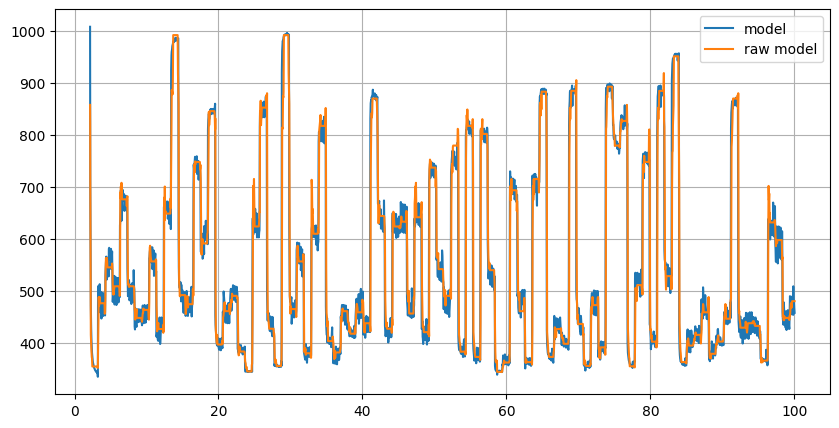

In [46]:
size = 10
system = System(size, model)

time   = df.time.values
input  = df.input.values
yModel = [system.update(u) for u in input]

plt.figure(figsize=(10, 5))
plt.plot(time, df.output, label='model')
plt.plot(time, yModel, label='raw model')
plt.legend(), plt.grid()
plt.show()